In [1]:
import logging

import equinox as eqx
import jax.numpy as jnp
import jax.random as jr
import jax.tree_util as jtu
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
from sklearn.metrics import average_precision_score, roc_auc_score
from tbparse import SummaryReader
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
from scipy.stats import binned_statistic_2d

from sepsis_osc.dnm.dynamic_network_model import DNMConfig, DNMMetrics
from sepsis_osc.ldm.data_loading import get_data_sets_online, prepare_batches_mask
from sepsis_osc.ldm.lookup import LatentLookup, as_2d_indices, get_aligned_subgrid
from sepsis_osc.ldm.model_structs import LossesConfig
from sepsis_osc.ldm.train_online import process_val_epoch
from sepsis_osc.storage.storage_interface import Storage
from sepsis_osc.utils.config import ALPHA, ALPHA_SPACE, BETA_SPACE, SIGMA_SPACE, jax_random_seed, plt_params
from sepsis_osc.utils.jax_config import setup_jax
from sepsis_osc.visualisations.viz_model_results import viz_heatmap_concepts, viz_plane

from sepsis_osc.ldm.checkpoint_utils import load_checkpoint
from sepsis_osc.ldm.model_structs import LoadingConfig
setup_jax(simulation=False)
from sepsis_osc.utils.logger import setup_logging

setup_logging()
logger = logging.getLogger(__name__)

from matplotlib.pyplot import Axes, Figure
from matplotlib import colors
from matplotlib.gridspec import GridSpec
from matplotlib.cm import ScalarMappable

from sepsis_osc.visualisations.viz_param_space import space_plot
from sepsis_osc.ldm.lookup import LatentLookup

plt.rcParams.update(plt_params)

In [2]:
(
    train_x,
    train_y,
    train_m,
    val_x,
    val_y,
    val_m,
    test_x,
    test_y,
    test_m,
) = get_data_sets_online(swapaxes_y=(1, 2, 0), dtype=jnp.float32, path_prefix="..")
for y, m, s in ((train_y, train_m, "Train"), (val_y, val_m, "Val"), (test_y, test_m, "Test")):
    print(f"Prevalence {s} Set {((y * m[..., None]).max(axis=1) == 1.0).mean(axis=0) * 100}%")
    
key = jr.PRNGKey(jax_random_seed)
test_x, test_y, test_m, _ = prepare_batches_mask(test_x, test_y, test_m, test_x.shape[0], key=key)
test_x, test_y, test_m = test_x[0], test_y[0], test_m[0]  # strip mini-epoch dimension

#test_x, test_y, test_m = test_x[None], test_y[None], test_m[None]

loss_conf = LossesConfig(
    lambda_sep3=300.0,
    lambda_inf=1.0,
    lambda_sofa_classification=2000.0,
    lambda_spreading=6e-3,
    lambda_boundary=30.0,
    lambda_recon=2.5,
)

2026-02-11 11:25:54 - sepsis_osc.ldm.data_loading    - INFO     - Processed sequence files found. Loading data from disk...
2026-02-11 11:25:55 - sepsis_osc.ldm.data_loading    - INFO     - Data loaded successfully.


Prevalence Train Set [13.18486401  7.84391013  5.29365392]%
Prevalence Val Set [13.66861107  8.05612486  5.02916601]%
Prevalence Test Set [13.15042573  8.04162725  4.96688742]%


In [3]:
betas = np.arange(BETA_SPACE[0], BETA_SPACE[1], BETA_SPACE[2])
sigmas = np.arange(SIGMA_SPACE[0], SIGMA_SPACE[1], SIGMA_SPACE[2])
alphas = np.arange(ALPHA_SPACE[0], ALPHA_SPACE[1], ALPHA_SPACE[2])

# DATA
db_str = "DaisyFinal"
sim_storage = Storage(
    key_dim=9,
    metrics_kv_name=f"../data/{db_str}SepsisMetrics.db/",
    parameter_k_name=f"../data/{db_str}SepsisParameters_index.bin",
    use_mem_cache=True,
)
sim_storage.close()
b, s = as_2d_indices(BETA_SPACE, SIGMA_SPACE)
a = np.ones_like(b) * ALPHA
indices_2d = jnp.concatenate([b[..., np.newaxis], s[..., np.newaxis]], axis=-1)
spacing_2d = jnp.array([BETA_SPACE[2], SIGMA_SPACE[2]])
params = DNMConfig.batch_as_index(a, b, s, 0.2)
metrics_2d, _ = sim_storage.read_multiple_results(params, proto_metric=DNMMetrics, threshold=0.0)
metrics_2d = metrics_2d.to_jax()
lookup_table = LatentLookup(
    metrics=metrics_2d.reshape((-1, 1)),
    indices=indices_2d.reshape((-1, 2)),  # since param space only alpha beta sigma
    metrics_2d=metrics_2d,
    indices_2d=indices_2d,
    grid_spacing=spacing_2d,
    dtype=jnp.float32,
)
assert metrics_2d

2026-02-11 11:25:57 - sepsis_osc.storage.storage_interface - INFO     - Got ../data/DaisyFinalSepsisParameters_index.bin and ../data/DaisyFinalSepsisMetrics.db/
2026-02-11 11:25:57 - sepsis_osc.storage.storage_interface - INFO     - FAISS index ../data/DaisyFinalSepsisParameters_index.bin loaded from disk.
2026-02-11 11:25:57 - sepsis_osc.storage.storage_interface - INFO     - Preloading memory cache from RocksDB...
2026-02-11 11:25:59 - sepsis_osc.storage.storage_interface - INFO     - Successfully loaded 76000 metrics into memory.
2026-02-11 11:25:59 - sepsis_osc.utils.utils         - INFO     - func:'__setup_memory_cache' took: 1.436450 sec
2026-02-11 11:25:59 - sepsis_osc.storage.storage_interface - INFO     - Getting Metrics for multiple queries with shape (60, 100, 9)
2026-02-11 11:25:59 - sepsis_osc.storage.storage_interface - INFO     - Searching 6000 keys in FAISS index
2026-02-11 11:25:59 - sepsis_osc.storage.storage_interface - INFO     - Found vectors with distance 0.0, ind

In [4]:
run_name = "best"
RUN_DIR = f"../runs/{run_name}"
tb_reader = SummaryReader(RUN_DIR)
tb_df = tb_reader.scalars

hparams = tb_reader.hparams.T
hparams.columns = hparams.loc["tag"]
hparams = hparams.drop("tag")

auprc = tb_df.query("tag == 'sepsis_metrics/AUPRC_pred_sep'")
prc_epoch = auprc.loc[auprc["value"].idxmax(), "step"]
auroc = tb_df.query("tag == 'sepsis_metrics/AUROC_pred_sep'")
roc_epoch = auroc.loc[auroc["value"].idxmax(), "step"]
best_epoch = round((prc_epoch + roc_epoch) / 2)
print(
    f"Best Epoch: {best_epoch} with between AUPRC={auprc['value'].max():.3f}@{prc_epoch} AUROC={auroc['value'].max():.3f}@{roc_epoch}"
)
LOAD_EPOCH = best_epoch

key = jr.PRNGKey(jax_random_seed)

load_conf = LoadingConfig(from_dir=RUN_DIR, epoch=LOAD_EPOCH)
if load_conf.from_dir:
    try:
        model, _ = load_checkpoint(load_conf.from_dir + "/checkpoints", load_conf.epoch, None)

    except FileNotFoundError as e:
        logger.warning(f"Error loading checkpoint: {e}.")
        load_conf.epoch = 0
        load_conf.from_dir = ""

model = eqx.nn.inference_mode(model)
assert model

Best Epoch: 258 with between AUPRC=0.104@260 AUROC=0.847@255


/home/unartig/Desktop/uni/ResearchProject/sepsis_osc/src/sepsis_osc/ldm/latent_dynamics_model.py:239: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  return LatentDynamicsModel(
2026-02-11 11:26:07 - sepsis_osc.ldm.checkpoint_utils - INFO     - Model checkpoint loaded for epoch 258 from ../runs/best/checkpoints/checkpoint_epoch_0258.eqx


In [5]:
def print_param_shapes(model):
    leaves_with_paths = jtu.tree_leaves_with_path(eqx.filter(model, eqx.is_array))
    total = 0
    print(f"{'Name':30} {'Shape':12}Parameter Count")
    for path, value in leaves_with_paths:
        # Convert path (tuple of keys) into readable string
        name = ".".join(str(p) for p in path)
        print(f"{name.strip("."):30} {str(value.shape):12}{value.size}")
        total += value.size
    print(f"Total: {total}")
print("+++ Infection Module Parameter +++")
print_param_shapes({"GRU-Cell": model.inf_encoder, "Proj": model.inf_proj_out})

print("+++ SOFA Module Parameter +++")
print_param_shapes(model.latent_pre_encoder)
print_param_shapes({"GRU-Cell": model.latent_encoder, "Proj": model.latent_proj_out})

print("+++ Decoder +++")
print_param_shapes(model.decoder)


+++ Infection Module Parameter +++
Name                           Shape       Parameter Count
['GRU-Cell']..weight_ih        (96, 104)   9984
['GRU-Cell']..weight_hh        (96, 32)    3072
['GRU-Cell']..bias             (96,)       96
['GRU-Cell']..bias_n           (32,)       32
['Proj']..weight               (1, 32)     32
['Proj']..bias                 (1,)        1
Total: 13217
+++ SOFA Module Parameter +++
Name                           Shape       Parameter Count
gating..weight                 (52, 52)    2704
norm1..weight                  (104,)      104
norm1..bias                    (104,)      104
linear1..weight                (64, 104)   6656
linear1..bias                  (64,)       64
norm2..weight                  (64,)       64
norm2..bias                    (64,)       64
linear2..weight                (64, 64)    4096
linear2..bias                  (64,)       64
norm3..weight                  (64,)       64
norm3..bias                    (64,)       64
linear3..we

In [6]:
test_metrics = process_val_epoch(
    model,
    x_data=test_x,
    y_data=test_y,
    mask_data=test_m,
    step=jnp.array(1e6, dtype=jnp.int32),
    key=key,
    lookup_func=lookup_table.hard_get_fsq,
    loss_params=loss_conf,
)

(6342, 169) (6342, 169)
(6342, 169) (6342, 169)
(6342, 169) (6342, 169)
(6342, 169) (6342, 169)
() ()
(6342, 169) (6342, 169)


2026-02-11 11:26:13 - sepsis_osc.utils.utils         - INFO     - func:'process_val_epoch' took: 5.877699 sec


In [7]:
true_sofa = np.asarray(test_y[..., 0])[test_m]
true_sofa_d2 = np.concat(
    [np.zeros(test_y.shape[:-2])[..., None], np.asarray(jnp.diff(test_y[..., 0], axis=-1) > 0)], axis=-1
)[test_m]
true_inf = np.asarray(test_y[..., 1])[test_m]
true_sep3 = np.asarray(test_y[..., 2] == 1.0)[test_m]
pred_sep3_risk = np.asarray(test_metrics.sep3_risk)[test_m]
pred_sofa_d2_risk = np.asarray(test_metrics.sofa_d2_risk)[test_m]
pred_susp_inf_p = np.asarray(test_metrics.susp_inf_p)[test_m]
pred_sofa_score = np.asarray(test_metrics.hists_sofa_score)[test_m]

print(f"AUROC sepis-3  {roc_auc_score(true_sep3, pred_sep3_risk) * 100:.3f}")
print(f"AUPRC sepis-3  {average_precision_score(true_sep3, pred_sep3_risk) * 100:.3f}")
print(f"AUROC sofa d2  {roc_auc_score(true_sofa_d2, pred_sofa_d2_risk) * 100:.2f}")
print(f"AUPRC sofa d2  {average_precision_score(true_sofa_d2, pred_sofa_d2_risk) * 100:.2f}")
print(f"AUROC susp inf {roc_auc_score(true_inf > 0, pred_susp_inf_p) * 100:.2f}")
print(f"AUPRC susp inf {average_precision_score(true_inf > 0, pred_susp_inf_p) * 100:.2f}")

AUROC sepis-3  84.694
AUPRC sepis-3  9.870
AUROC sofa d2  55.31
AUPRC sofa d2  5.72
AUROC susp inf 72.55
AUPRC susp inf 20.63


In [18]:
def viz_heatmap_concepts(
    true_sofa: jnp.ndarray | np.ndarray,
    true_infs: jnp.ndarray | np.ndarray,
    pred_sofa: jnp.ndarray | np.ndarray,
    pred_infs: jnp.ndarray | np.ndarray,
    *,
    cmap: bool,
    figax: tuple[Figure, tuple[Axes, Axes, Axes]] | None = None,
) -> tuple[Figure, tuple[Axes, Axes, Axes]]:
    if figax is not None:
        fig, ax = figax
    else:
        fig, ax = plt.subplots(1, 3)

    sofa_bins = [np.arange(-0.5, 24.5, 1), np.arange(-0.5, 24.5, 1)]
    sofa_heatmap = np.histogram2d(true_sofa, pred_sofa, bins=sofa_bins)
    sofa = (sofa_heatmap, "SOFA-score", ax[0])

    dsofa_bins = [np.arange(-24.5, 24.5, 1), np.arange(-24.5, 24.5, 1)]  # 1-point bins
    dsofa_heatmap = np.histogram2d(np.diff(true_sofa), np.diff(pred_sofa), bins=dsofa_bins)
    dsofa = (dsofa_heatmap, r"$\Delta$SOFA-score", ax[1])

    infection_bins = [np.arange(-0.05, 1.05, 0.1), np.arange(-0.05, 1.05, 0.1)]
    inf_heatmap = np.histogram2d(true_infs, pred_infs, bins=infection_bins)
    inf = (inf_heatmap, "Suspected Infection", ax[2])
    
    heats = np.log(
        np.concat(
            [
                np.asarray(sofa_heatmap[0]).flatten(),
                np.asarray(dsofa_heatmap[0]).flatten(),
                np.asarray(inf_heatmap[0]).flatten(),
            ]
        )
        + 1
    )
    norm = colors.Normalize(vmin=np.min(heats), vmax=np.max(heats))

    images = []
    for (heatmap, xedges, yedges), name, axi in [sofa, dsofa, inf]:
        # Plot the 2D histogram as an image
        images.append(
            axi.imshow(
                np.log(heatmap.T + 1),  # transpose so it matches axes orientation
                origin="lower",
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                aspect="equal",
                cmap="magma",
                norm=norm,
            )
        )
        axi.set_title(name)
        axi.set_xlabel(f"Ground Truth")
        axi.plot((xedges[0], xedges[-1]), (yedges[0], yedges[-1]), color="red", label="Optimal", linestyle=":")
    if cmap:
        pos = ax[-1].get_position()

        # Create colorbar axes outside the plot
        cax = fig.add_axes([pos.x1 + 0.02, pos.y0, 0.02, pos.height])
        fig.colorbar(images[-1], cax=cax, label="log(Count)")

    ax[0].legend( bbox_to_anchor=(3.85, 1.175))
    ax[0].set_ylabel(f"Predicted")
    fig.subplots_adjust(wspace=0.2)
    return fig, ax

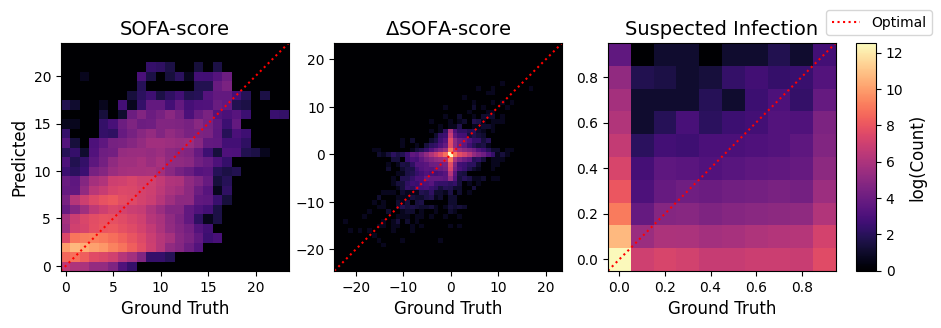

In [19]:
heat_fig, heat_ax = viz_heatmap_concepts(
    true_sofa,
    true_inf,
    pred_sofa_score,
    pred_susp_inf_p,
    cmap=True,
)

In [20]:
heat_fig.savefig("../typst/images/heat.svg")
heat_fig.savefig("../typst/images/paper/heat.png", dpi=400)

In [14]:
def plot_patient(patient_idx: list[int]) -> Figure:
    if not isinstance(patient_idx, list):
        patient_idx = [patient_idx]
        
    fig = plt.figure()
    gs = GridSpec(len(patient_idx), 2, figure=fig, width_ratios=[1.3, 1], wspace=0.2, hspace=0.4)
    axl = fig.add_subplot(gs[:, 0])

    cs = ["tab:cyan", "tab:purple", "tab:pink", "tab:orange"]

    viz_plane(
        true_sofa=test_y[0, patient_idx, :, 0],
        betas=test_metrics.beta[0, patient_idx],
        sigmas=test_metrics.sigma[0, patient_idx],
        mask=test_m[0, patient_idx],
        zoom=True,
        window_size=5,
        lookup=lookup_table,
        cmaps=True,
        figax=(fig, axl),
        cs=cs
    )

    for i, pidx in enumerate(patient_idx):
        axr = fig.add_subplot(gs[i, 1])
        m = test_m[0, pidx]
        axr.plot(test_y[0, pidx, :, 0][m], label=f"Ground Truth")
        axr.plot(test_metrics.hists_sofa_score[0, pidx, :][m], label=f"Prediction")
        axr.set_ylim(0, 24)
        axr.set_ylabel(f"Patient {i+1}", color=cs[i])
        axr.set_ylim(0, 24)
        axr.set_yticks(range(25)) 
        
        axr.grid(visible=True, axis='y', which='major', color='gray', linestyle=':', alpha=0.4)
        axr.set_yticks([0, 4, 8, 12, 16, 20, 24], minor=False)
        axr.set_yticks(np.arange(0, 25, 2), minor=True)
        
        axr.grid(visible=True, axis='y', which='both', alpha=0.8)
        if i == 0:
            axr.set_title("SOFA-score")
            axr.legend(ncols=2, bbox_to_anchor=(1, 1.5 + 0.05 * len(patient_idx)), frameon=False)
        if i == len(patient_idx) - 1:
                axr.set_xlabel("time [hours]")

    if False:
        axrs[i].plot(test_metrics.sofa_d2_p[0, patient_idx, :][test_m[0, patient_idx]]*24)
        axrs[i].plot(
            causal_smoothing(test_metrics.sofa_d2_p[0, patient_idx, :][test_m[0, patient_idx]][None, ...], 
                             radius=12, 
                             decay=model.sofa_d2_pred_smooth)[0]*24, label="CS(A_t)")
    
    return fig


[1086 6288 4954 4413 2844 1628 6316 3908 2360 4494]
[3442 4608 5814 1086 4916 1207 4720 2692 5400 4494]
[5448 1959 2697  758 3544 5350  633 5562 3200 1732 3882 2278 2706   97
 4917 4916 1943 3066  856 6187]
[1132 2619  962 5114 1943 1947 5482 2268 3434 2559 4304 4199 1251 3645
 5606 3083 4048 1109  480 3292]


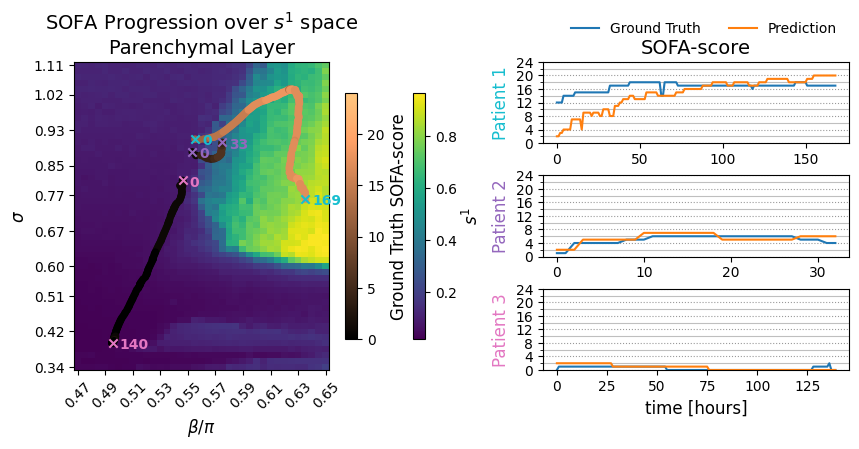

In [15]:
# 4494 3908

# highest sofa std in first batch
p_idx = np.argsort(test_y[0, :, :, 0].std(axis=-1))[-10:]
print(p_idx)
# highest sofa std in first batch
p_idx = np.argsort(test_y[0, :, :, 0].max(axis=-1))[-10:]
print(p_idx)
# largest increase
p_idx = np.argsort((np.diff(test_y[0, :, :, 0], axis=-1).sum(axis=-1) == 1))[-20:]
print(p_idx)
# best predictions
p_idx = np.argsort(np.square(test_y[0, :, :, 0] - test_metrics.hists_sofa_score[0, :]).mean(axis=-1))[:20]
print(p_idx)
# highest sofa decrease
# 10 24 23 33 54 61 70
# 70

# worsening 5332, 4608, 5814
# recover 16 29, 84, 107
# healthy 18, 62 5114, 4199, 1251, 137, 141, 147, 150, 157
p_idx = [5814, 107, 5114]
patient_fig = plot_patient(p_idx)
plt.show()

In [16]:
patient_fig.savefig(f"../typst/images/trajectory.svg")
patient_fig.savefig(f"../typst/images/paper/trajectory.png", dpi=400)

In [23]:
def viz_space_heatmap(
    betas: jnp.ndarray,
    sigmas: jnp.ndarray,
    lookup: LatentLookup,
    *,
    mask: np.ndarray,
    cmaps: bool = True,
    figax: tuple[Figure, Axes] | None = None,
) -> tuple[Figure, Axes]:
    if figax is not None:
        fig, axs = figax
    else:
        fig, axs = plt.subplots(1, 2, sharey=True, width_ratios=[1.4, 1.0])

    ax0, ax1 = axs[0], axs[1]
    betas_space = jnp.arange(*BETA_SPACE)
    sigmas_space = jnp.arange(*SIGMA_SPACE)
    beta_grid, sigma_grid = np.meshgrid(betas_space, sigmas_space, indexing="ij")
    param_grid = np.stack([beta_grid.ravel(), sigma_grid.ravel()], axis=1)

    metrics = lookup.hard_get_fsq(jnp.asarray(param_grid)).reshape(len(betas_space), len(sigmas_space))

    std_sym = r"$s^{1}$"
    space_plot(
        metrics,
        xs=np.asarray(betas_space),
        ys=np.asarray(sigmas_space),
        title=rf"",
        cmap=cmaps,
        figax=(fig, ax0),
        filename="",
    )
    ax1 = space_plot(
        metrics,
        xs=np.asarray(betas_space),
        ys=np.asarray(sigmas_space),
        title=rf"",
        cmap=False,
        figax=(fig, ax1),
        filename="",
    )
    
    N, T = betas.shape
    reso = 0.25
    bins = [np.arange(BETA_SPACE[0], BETA_SPACE[1], BETA_SPACE[2]*reso), 
            np.arange(SIGMA_SPACE[0], SIGMA_SPACE[1], SIGMA_SPACE[2]*reso)]
    heatmap, xedges, yedges = np.histogram2d(betas[mask], sigmas[mask], bins=bins)
    heatmap = heatmap[:, ::-1].T
    
    alpha = np.ones_like(heatmap, dtype=np.float32)
    alpha[heatmap == 0] = 0.0 

    im = ax0.images[0]
    extent = im.get_extent()
    
    im_count = ax0.imshow(
        np.log(heatmap + 1),
        extent=extent,
        aspect="auto",
        cmap="OrRd_r",
        alpha=alpha
    )
    cbar = fig.colorbar(im_count, ax=ax0, location="left", shrink=0.8)
    cbar_ax = cbar.ax
    pos = cbar_ax.get_position()
    cbar_ax.set_position([pos.x0 - 0.05, pos.y0, pos.width, pos.height])
    cbar.set_label(r"$log(Count)$")

    cbar = ax0.images[0].colorbar
    cbar_ax = cbar.ax
    pos = cbar_ax.get_position()
    cbar_ax.set_position([pos.x0+0.03, pos.y0, pos.width, pos.height])

    # scatter
    # Same bins you used for the count heatmap
    x = betas[mask]
    y = sigmas[mask]
    values = test_y[0, mask, 0]  # SOFA score
    
    mean_map, xedges, yedges, _ = binned_statistic_2d(
        x, y, values,
        statistic='mean',
        bins=bins
    )
    
    # Match orientation to your earlier heatmap
    mean_map = mean_map[:, ::-1].T
    alpha_mean = ~np.isnan(mean_map)
    mean_map = np.nan_to_num(mean_map, nan=0.0)
    cm = plt.colormaps.get_cmap("copper")
    norm = colors.Normalize(vmin=0, vmax=24)
    
    im_mean = ax1.imshow(
        mean_map,
        extent=extent,
        aspect="auto",
        cmap=cm,
        norm=norm,
        alpha=alpha_mean.astype(float)
    )
    
    cbar = fig.colorbar(im_mean, ax=ax1, location="right", shrink=0.8)
    cbar.set_label("Mean of the ground truth SOFA-score")
    """
    beta_scale = len(betas_space) * (betas[mask] - betas_space[0]) / (betas_space[-1] - betas_space[0])
    sigma_scale = len(sigmas_space) * (1 - (sigmas[mask] - sigmas_space[0]) / (sigmas_space[-1] - sigmas_space[0]))

    cm = plt.colormaps.get_cmap("copper")
    norm = colors.Normalize(vmin=0, vmax=24)

    scat = ax1.scatter(beta_scale, sigma_scale, c=test_y[0, mask, 0], cmap=cm, norm=norm, s=5, alpha=1.0, rasterized=True)
    sm = ScalarMappable(cmap=cm, norm=norm)
    cbar = fig.colorbar(sm, ax=ax1, location="right", shrink=0.8)
    cbar.set_label(r"Ground truth SOFA-score")
    sm = ScalarMappable(cmap=cm, norm=norm)
    sm.set_array([])
    sm.set_clim(0, 24)
    """
    ax1.set_xlabel(r"$\beta / \pi$")
    ax0.set_xlabel(r"$\beta / \pi$")
    ax0.set_ylabel(r"$\sigma$")
    ax1.set_ylabel("")
    #fig.subplots_adjust(wspace=0.2)
    ax0.text(-0.3, 1.1, 'A', transform=ax0.transAxes, fontsize=14, fontweight='bold', va='top')
    ax0.text(-0.1, 1.1, 'B', transform=ax1.transAxes, fontsize=14, fontweight='bold', va='top')
    return fig, axs

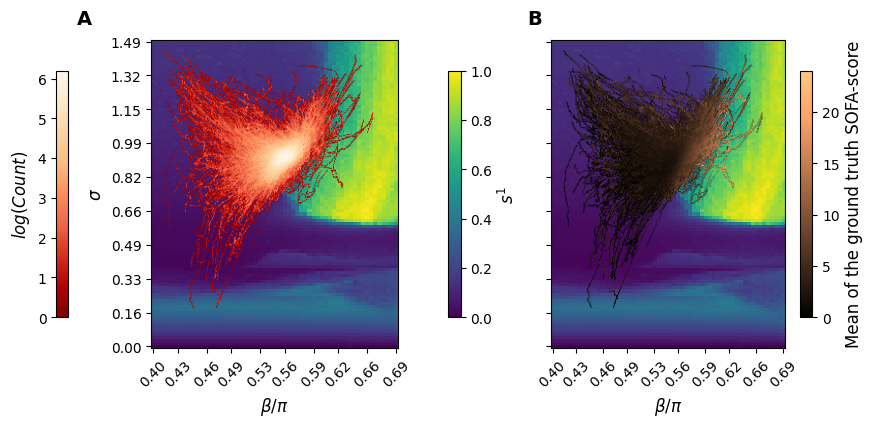

In [24]:
heat_space_fig, ax = viz_space_heatmap(
    test_metrics.beta[0],
    test_metrics.sigma[0],
    lookup=lookup_table,
    mask=test_m[0],
)

In [22]:
heat_space_fig.savefig("../typst/images/heat_space.svg")
heat_space_fig.savefig("../typst/images/paper/heat_space.png", dpi=400)
heat_space_fig.savefig("../typst/images/heat_space.png", dpi=400)

In [365]:
def viz_loss() -> Figure:
    fig, axs = plt.subplots(3, 3, sharex=True)
    
    data_train = tb_df.query(f"tag == 'train_losses/total_loss_mean'")
    data_val = tb_df.query(f"tag == 'val_losses/total_loss_mean'")
    axs[0, 0].plot(data_train["step"], data_train["value"], label="Training")
    axs[0, 0].plot(data_val["step"], data_val["value"], label="Validation")
    axs[0, 0].legend(ncols=2, bbox_to_anchor=(2.4, 1.75), frameon=False)
    axs[0, 0].set_title(r"log($L_\text{total}$)")
    axs[0, 0].grid(True)
    axs[0, 0].set_yscale("log")
    print((data_train["value"]).to_numpy()[[0, -1]], (data_val["value"]).to_numpy()[[0, -1]])

    data = tb_df.query(f"tag == 'sepsis_metrics/AUROC_pred_sep'")
    axs[0, 1].plot(data["step"], data["value"], c="tab:orange")
    axs[0, 1].set_title(r"AUROC")
    axs[0, 1].grid(True)
    
    data = tb_df.query(f"tag == 'sepsis_metrics/AUPRC_pred_sep'")
    axs[0, 2].plot(data["step"], data["value"], c="tab:orange")
    axs[0, 2].set_title(r"AUPRC")
    axs[0, 2].grid(True)
    
    losses = ("sepsis-3", "sofa", "infection", "recon_loss", "spreading_loss", "boundary_loss")
    loss_subscripts = ("sepsis", "sofa", "inf", "dec", "spread", "boundary")
    lambdas = ("sep3", "sofa_classification", "inf", "recon", "spreading", "boundary")

    #axs = np.empty((2, 3), dtype=np.object_)
    for i, (loss, subscript, weight) in enumerate(zip(losses, loss_subscripts, lambdas, strict=True)):
        ax = axs[i//3 + 1, i%3]
        data_train = tb_df.query(f"tag == 'train_losses/{loss}_mean'")
        data_val = tb_df.query(f"tag == 'val_losses/{loss}_mean'")
        llambda = hparams.loc["value", f"losses_lambda_{weight}"]
        print(loss,(data_train["value"]*llambda).to_numpy()[[0, -1]], (data_val["value"]*llambda).to_numpy()[[0, -1]])
        ax.plot(data_train["step"], data_train["value"]*llambda, label="Training")
        ax.plot(data_val["step"], data_val["value"]*llambda, label="Validation")
        ax.set_title(fr"$L_\text{'{'}{subscript}{'}'}\lambda_\text{'{'}{subscript}{'}'}$")
        ax.grid(True)
        if i//3 == 1:
            ax.set_xlabel("Epoch")

    fig.subplots_adjust(hspace=0.5)
    fig.subplots_adjust(wspace=0.3)
    return fig

[493.30990601  81.82611084] [477.58203125  93.64914703]
sepsis-3 [54.86987382 32.41729662] [53.75663191 33.32851008]
sofa [429.35204506  47.78277874] [415.03295302  58.73843655]
infection [0.60865456 0.20781447] [0.61046851 0.21599898]
recon_loss [7.98867404 1.25124454] [8.06976497 1.29327521]
spreading_loss [0.1124473  0.07281022] [0.11219606 0.07167995]
boundary_loss [0.         0.00052732] [0.         0.00125197]


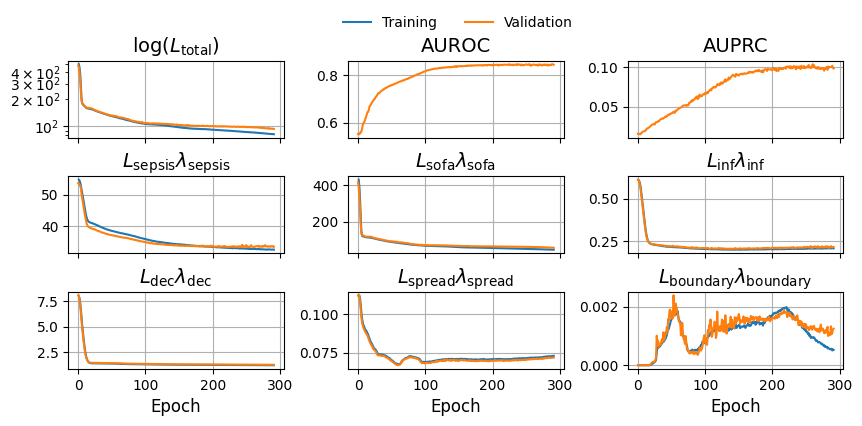

In [366]:
loss_fig = viz_loss()

In [367]:
loss_fig.savefig("../typst/images/losses.svg")
loss_fig.savefig("../typst/images/paper/losses.png", dpi=400)

In [368]:
def viz_areas() -> Figure:
    fig, ax = plt.subplots(1, 2)
    roc = RocCurveDisplay.from_predictions(
        true_sep3, pred_sep3_risk, ax=ax[0], curve_kwargs={"color": "tab:orange"}, plot_chance_level=True
    )
    roc.ax_.plot((0, 0), (1,1), label="random", color="red", linestyle=":")
    PrecisionRecallDisplay.from_predictions(true_sep3, pred_sep3_risk, ax=ax[1], color="tab:orange", plot_chance_level=True)

    ax[0].set_title("Receiver Operating Characteristics")
    ax[1].set_title("Precision Recall Curve")
    ax[1].legend(loc="upper right")

    return fig

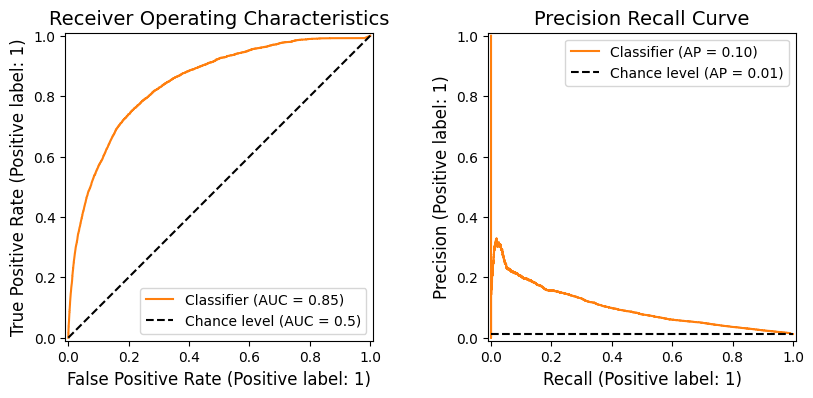

In [370]:
area_fig = viz_areas()

In [371]:
area_fig.savefig("../typst/images/areas.svg")
area_fig.savefig("../typst/images/paper/areas.png", dpi=400)

In [54]:
hparams.T

,value
tag,
losses_lambda_boundary,30.0
losses_lambda_inf,1.0
losses_lambda_recon,2.5
losses_lambda_sep3,600.0
losses_lambda_sofa_classification,2000.0
losses_lambda_spreading,0.006
losses_steps_per_epoch,0.0
lr_enc_wd,0.2
lr_init,0.0
